# 0. Introduction

This notebook analyses the predictions of the model
We look at following models:
- linear regression
- SVR
- XGBoost

For these models we will analyse the predictions and try to explain these with SHAP

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
import shap

In [2]:
sns.set_theme(palette="colorblind", rc={'figure.figsize':(14, 10)})

# 1. Data

In [3]:
df = pd.read_excel(r"C:\Users\32474\Documents\Ma TEW\masterthesis\data\modelling_data.xlsx")
df.drop("Unnamed: 0", axis=1, inplace=True)

In [4]:
# select all the row other than deal price as independent variables
X = df.iloc[:, 2:]
# select log deal price as target
y = df.iloc[:, 1]

In [5]:
# create a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
y_train.mean()

414815793.1826438

In [7]:
y_test.mean()

589108973.4133065

# 2. Models

In [8]:
lr = pickle.load(open('lr_model3.sav', 'rb'))

In [9]:
svr = pickle.load(open('svr_model3.sav', 'rb'))

In [10]:
xgb = pickle.load(open('xgb_model3.sav', 'rb'))

# 3. Error distributions

In [11]:
def plot_prediction_results(model, X, y):
    pred = cross_val_predict(model, X, y)
    errors = abs(y - pred)
    fig, axs = plt.subplots(ncols=2, figsize=(20,10))
    sns.histplot(x=errors, ax=axs[0])
    sns.regplot(x=pred, y=y, ax=axs[1])

## 3.1. Linear regression

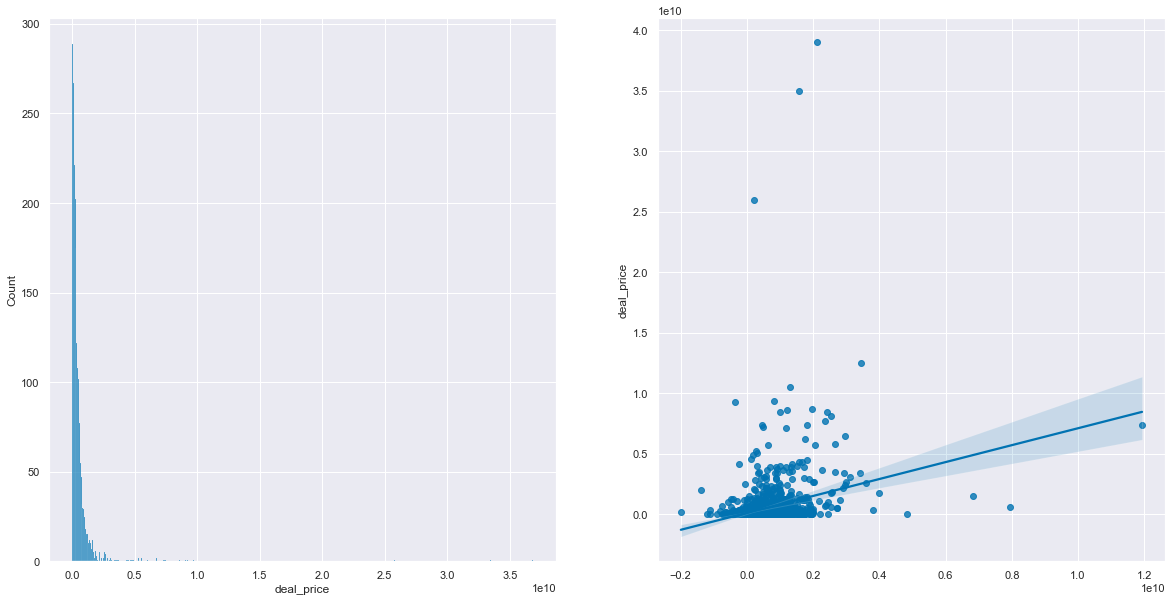

In [12]:
plot_prediction_results(lr, X_train, y_train)

## 3.2. SVR

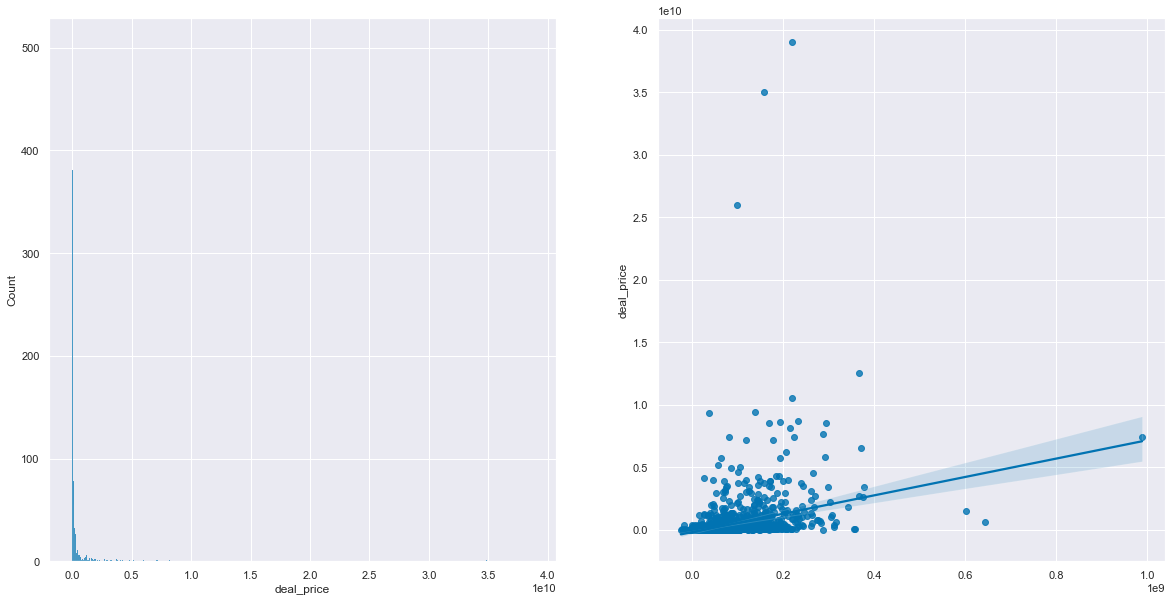

In [13]:
plot_prediction_results(svr, X_train, y_train)

## 3.3. XGBBoost

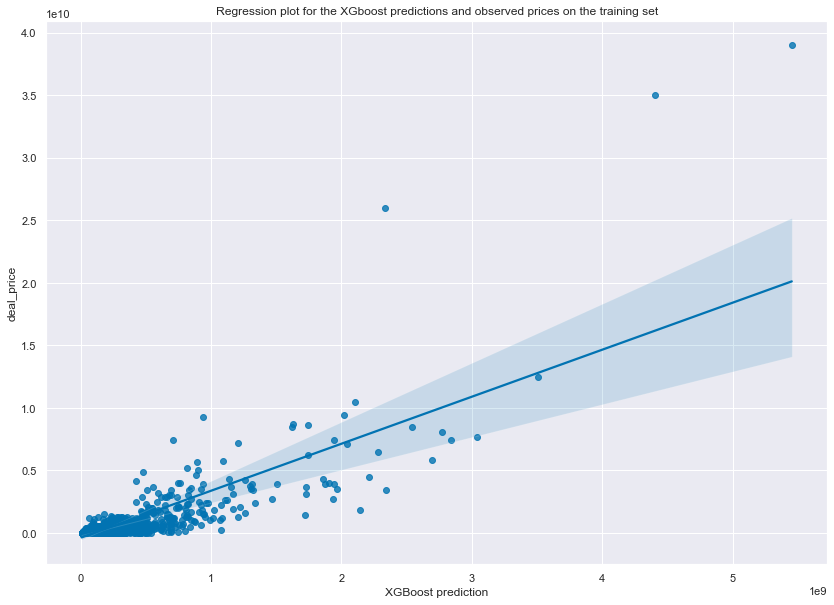

In [14]:
pred_train = xgb.predict(X_train)
sns.regplot(x=pred_train, y=y_train)
plt.xlabel('XGBoost prediction')
plt.title('Regression plot for the XGboost predictions and observed prices on the training set')
plt.savefig(r"C:\Users\32474\Documents\Ma TEW\masterthesis\grafieken\XGBoost prediciton training", bbox_inches='tight')

<AxesSubplot:ylabel='deal_price'>

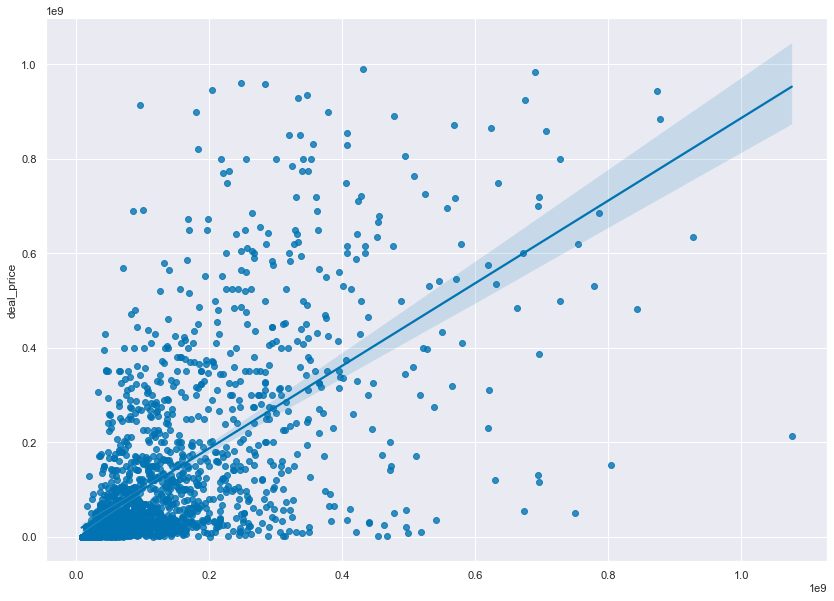

In [15]:
sns.regplot(x=pred_train[y_train < 1_000_000_000], y=y_train[y_train < 1_000_000_000])

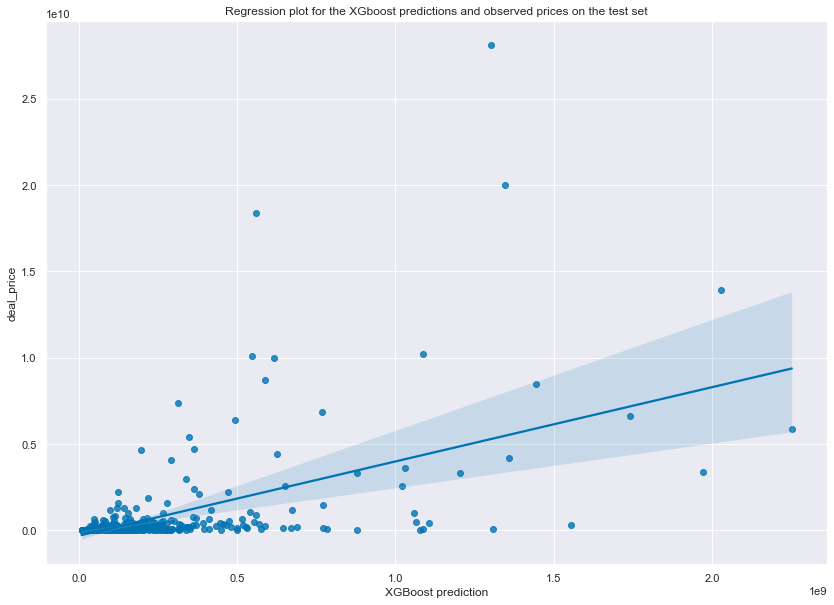

In [16]:
pred_test = xgb.predict(X_test)
sns.regplot(x=pred_test, y=y_test)
plt.xlabel('XGBoost prediction')
plt.title('Regression plot for the XGboost predictions and observed prices on the test set')
plt.savefig(r"C:\Users\32474\Documents\Ma TEW\masterthesis\grafieken\XGBoost prediciton test", bbox_inches='tight')

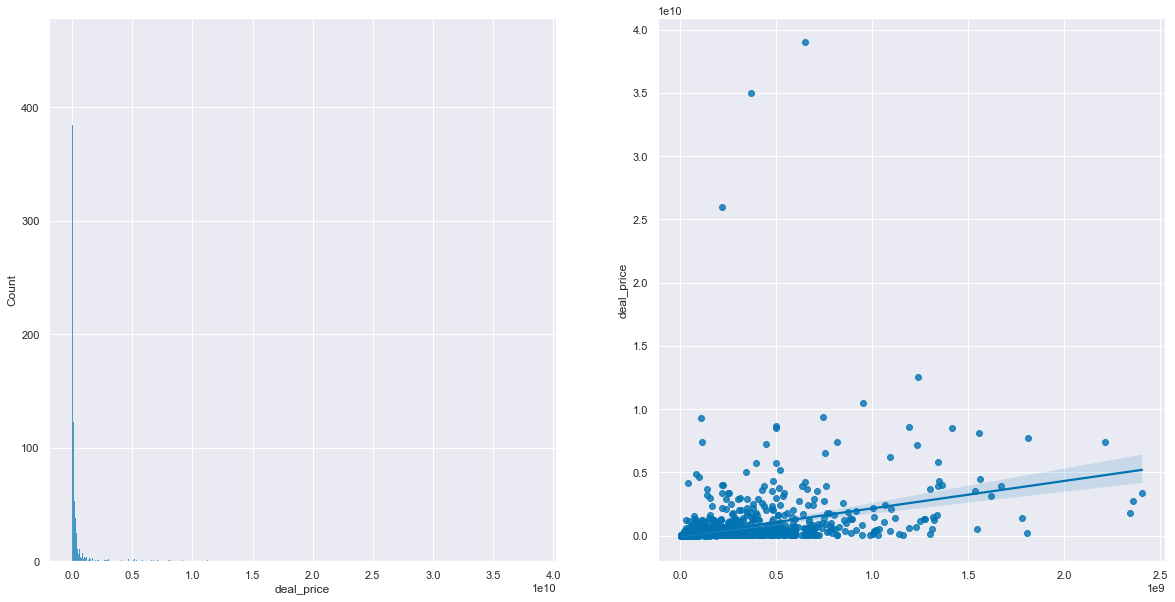

In [17]:
plot_prediction_results(xgb, X_train, y_train)

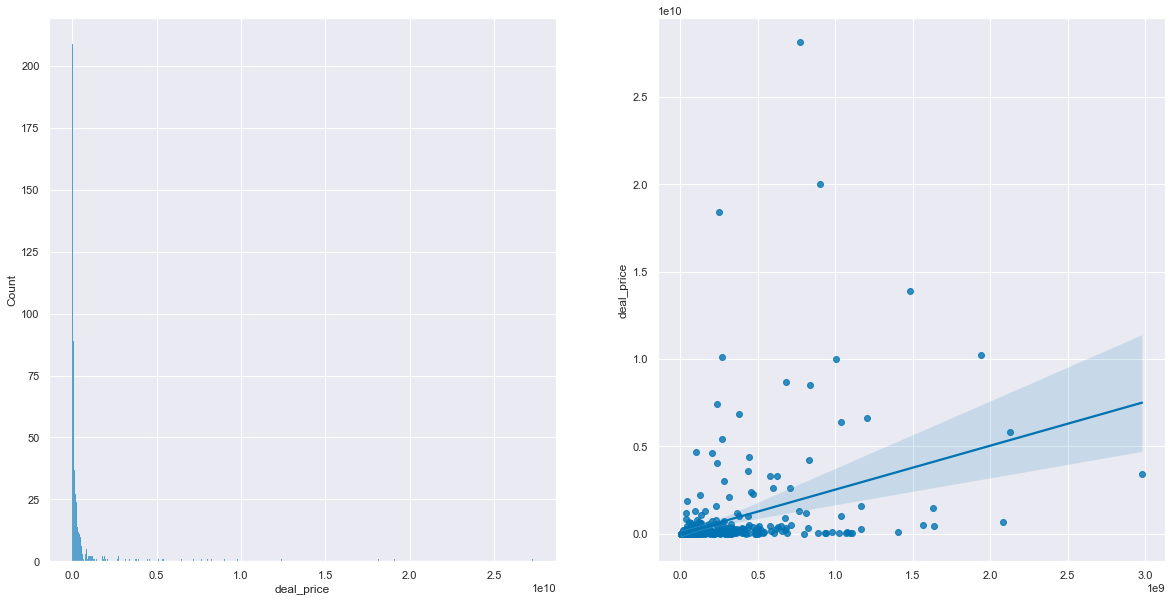

In [18]:
plot_prediction_results(xgb, X_test, y_test)

# 4. SHAP for XGBoost

## 4.1. Predictions on training set

In [17]:
# create shap values based on the xgb model only (SHAP does not support the pipeline as of now)
explainer = shap.explainers.Tree(xgb['xgb'])
shap_values = explainer.shap_values(xgb['scaler'].transform(X_train))

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [18]:
explainer.expected_value

217813570.0

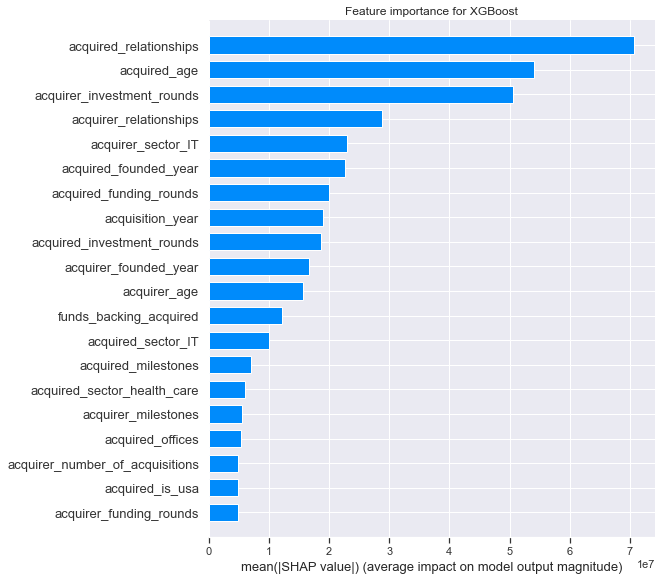

In [19]:
shap.summary_plot(shap_values, xgb['scaler'].transform(X_train), feature_names=X_train.columns, plot_type='bar', show=False)
plt.title("Feature importance for XGBoost")
plt.savefig(r"C:\Users\32474\Documents\Ma TEW\masterthesis\grafieken\XGBoost feature importance", bbox_inches='tight')
plt.show()

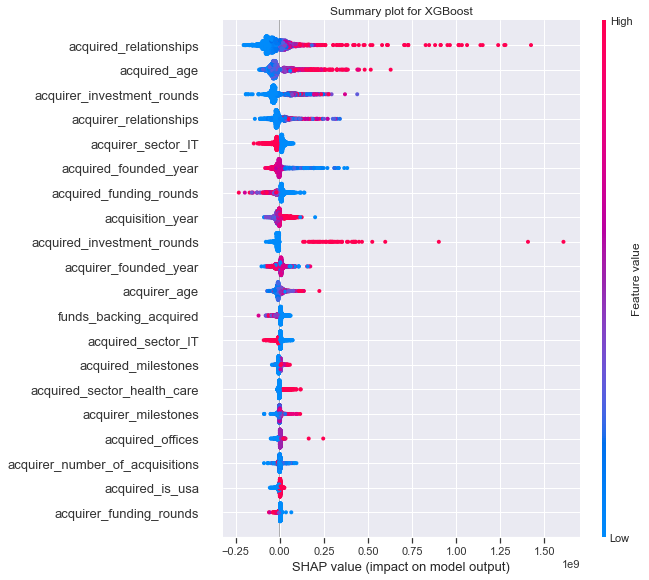

In [20]:
shap.summary_plot(shap_values, xgb['scaler'].transform(X_train), feature_names=X_train.columns, show=False)
plt.title("Summary plot for XGBoost")
plt.savefig(r"C:\Users\32474\Documents\Ma TEW\masterthesis\grafieken\XGBoost summary plot", bbox_inches='tight')
plt.show()

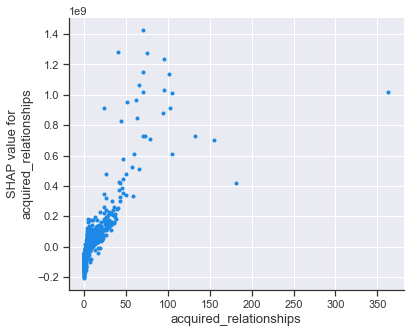

In [21]:
shap.dependence_plot('acquired_relationships', shap_values, X_train, interaction_index=None)

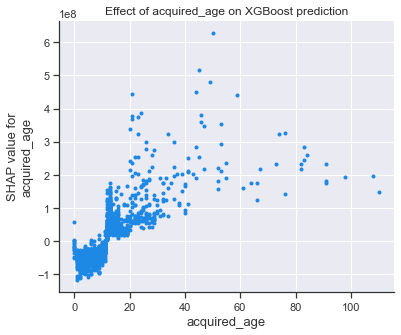

In [22]:
shap.dependence_plot('acquired_age', shap_values, X_train, interaction_index=None, show=False)
plt.title("Effect of acquired_age on XGBoost prediction")
plt.savefig(r"C:\Users\32474\Documents\Ma TEW\masterthesis\grafieken\influence of age on prediction", bbox_inches='tight')
plt.show()

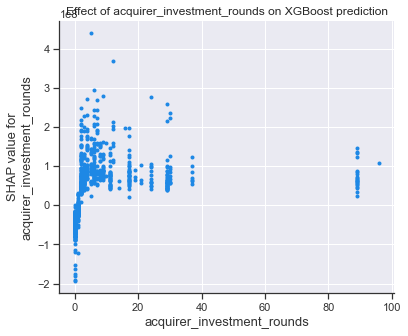

In [23]:
shap.dependence_plot('acquirer_investment_rounds', shap_values, X_train, interaction_index=None, show=False)
plt.title("Effect of acquirer_investment_rounds on XGBoost prediction")
plt.savefig(r"C:\Users\32474\Documents\Ma TEW\masterthesis\grafieken\influence of investment on prediction", bbox_inches='tight')
plt.show()

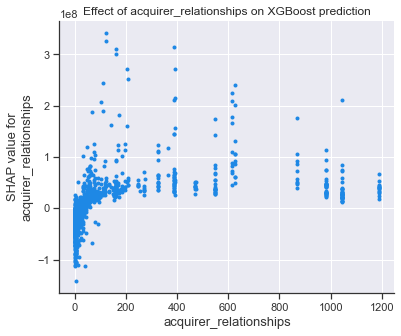

In [24]:
shap.dependence_plot('acquirer_relationships', shap_values, X_train, interaction_index=None, show=False)
plt.title("Effect of acquirer_relationships on XGBoost prediction")
plt.savefig(r"C:\Users\32474\Documents\Ma TEW\masterthesis\grafieken\influence of relationships on prediction", bbox_inches='tight')
plt.show()

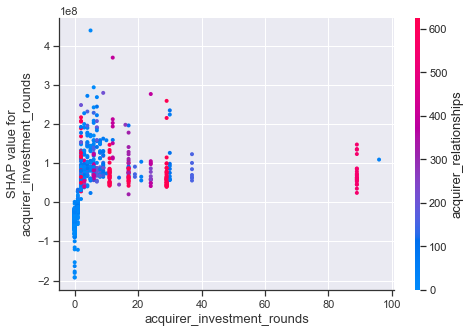

In [25]:
shap.dependence_plot('acquirer_investment_rounds', shap_values, X_train, interaction_index='acquirer_relationships')

**Conclusions**
- most important variables (1) acquired_relationships, (2) acquired_age and (3) acquirer_investment_rounds
- most variables have a clear direction in which they push the prediction (IE acquired_relationships and acquired_age)
- some have more 'obscure' patterns (IE acquirer_investment_rounds and acquirer_relationships). Here we see that very low scores push the prediction down, higher scores make the effect positive but the magnitude of the effect is not clear
- no direct clean interation effects could be found here.

### 4.1.1. Does the model learn theoretical concepts?

M&A can be both "big buys small" and "like buys like" transactions
In "Like buys Like" transactions the power of each company is more equal
This results in a fairer distribution of the value that the deal creates, in other words the deal price rises
If the acquiring company has more power it can undercut the value of the acquiree, resulting in a lower deal price

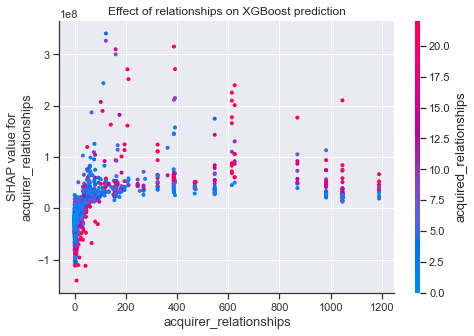

In [26]:
shap.dependence_plot('acquirer_relationships', shap_values, X_train, interaction_index='acquired_relationships', show=False)
plt.title("Effect of relationships on XGBoost prediction")
plt.savefig(r"C:\Users\32474\Documents\Ma TEW\masterthesis\grafieken\influence of relationships on prediction", bbox_inches='tight')
plt.show()

it seems that highly connected acquirers tend to buy highly connected acquiree's,
although it can also be the case that a less connected buyer (is he really less connected?) buys a well connected or vise versa

both being well connected seems to drive price up
-> like buys like and big drives up the price (but we have examtions on this)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


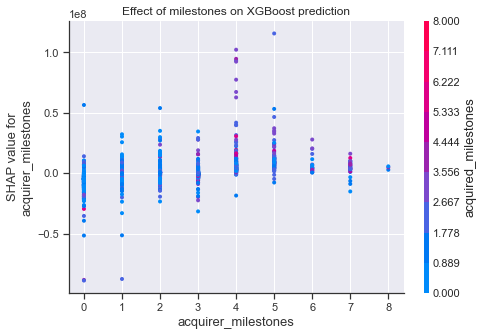

In [27]:
shap.dependence_plot('acquirer_milestones', shap_values, X_train, interaction_index='acquired_milestones', show=False)
plt.title("Effect of milestones on XGBoost prediction")
plt.savefig(r"C:\Users\32474\Documents\Ma TEW\masterthesis\grafieken\influence of milestones on prediction", bbox_inches='tight')
plt.show()

again a slight view of like buys like
having some achievements for both companies seems more important to drive price -> both have bargaining power so the company cannot undercut the real price?

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


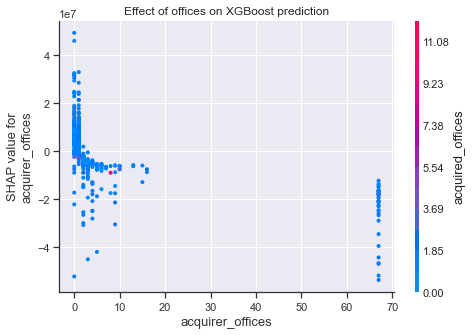

In [28]:
shap.dependence_plot('acquirer_offices', shap_values, X_train, interaction_index='acquired_offices', show=False)
plt.title("Effect of offices on XGBoost prediction")
plt.savefig(r"C:\Users\32474\Documents\Ma TEW\masterthesis\grafieken\influence of offices on prediction", bbox_inches='tight')
plt.show()

many offices seems to decrease the price
little interaction effect

offices can signal size and bargaining power, if very inbalanced this can decrease the price?
if around equal (both low), aka like buys like than higher price

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


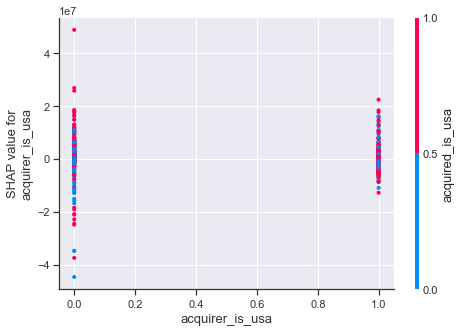

In [54]:
shap.dependence_plot('acquirer_is_usa', shap_values, X_train, interaction_index='acquired_is_usa')

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


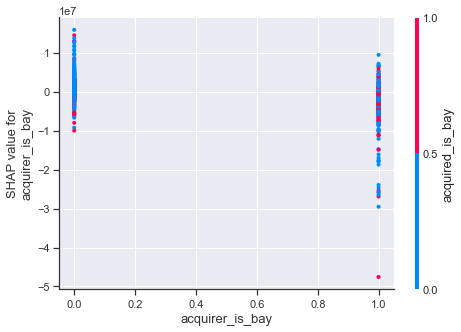

In [55]:
shap.dependence_plot('acquirer_is_bay', shap_values, X_train, interaction_index='acquired_is_bay')

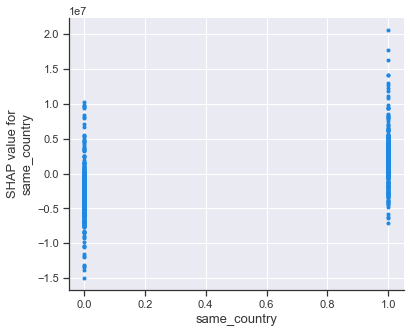

In [57]:
shap.dependence_plot('same_country', shap_values, X_train, interaction_index=None)

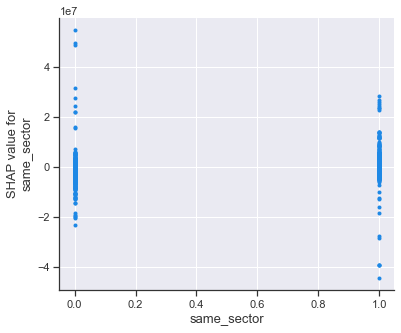

In [58]:
shap.dependence_plot('same_sector', shap_values, X_train, interaction_index=None)

In [59]:
df.same_sector.mean()

0.48184019370460046

In [60]:
df.same_country.mean()

0.5516545601291364

**Conclusion**

Many similar companies buy each other, both in terms of *size* and *locations* (size seems to be a loose trend, many examptions, location is about fifthy fifthy)

for size we see that being of similar size (like buys like) drives up the price, equal bargaining power makes sure the price is not undercut?
for the location this relationship to the dealprice is less likely.


## 4.2 Predictions for test set

In [31]:
# create shap values based on the xgb model only (SHAP does not support the pipeline as of now)
explainer = shap.explainers.Tree(xgb['xgb'])
shap_values = explainer.shap_values(xgb['scaler'].transform(X_test))

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [32]:
explainer.expected_value

217813570.0

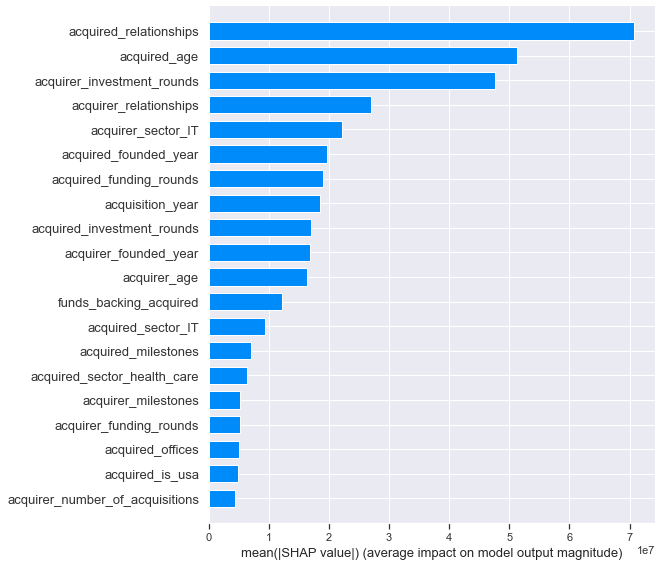

In [33]:
shap.summary_plot(shap_values, xgb['scaler'].transform(X_test), feature_names=X_test.columns, plot_type='bar')

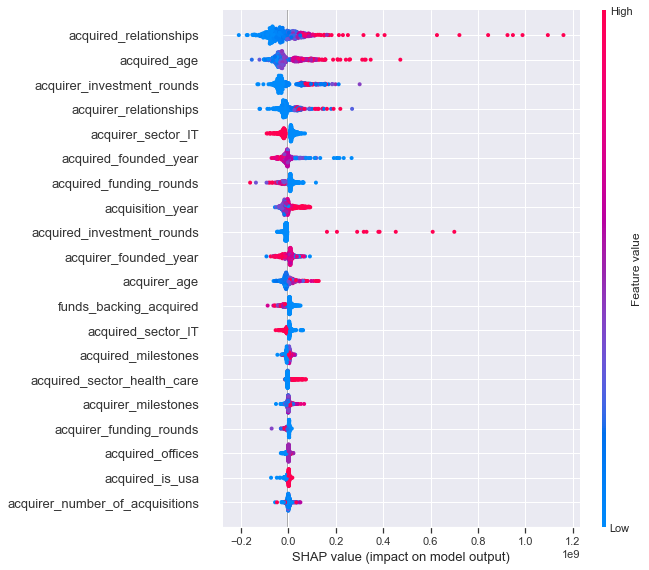

In [34]:
shap.summary_plot(shap_values, xgb['scaler'].transform(X_test), feature_names=X_test.columns)

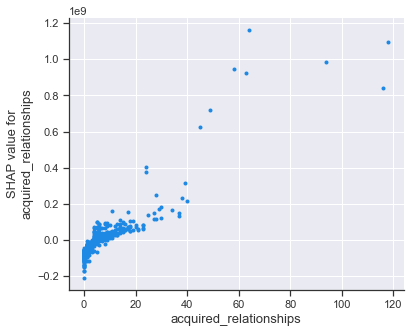

In [35]:
shap.dependence_plot('acquired_relationships', shap_values, X_test, interaction_index=None)

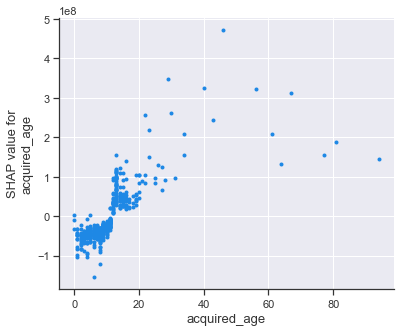

In [36]:
shap.dependence_plot('acquired_age', shap_values, X_test, interaction_index=None)

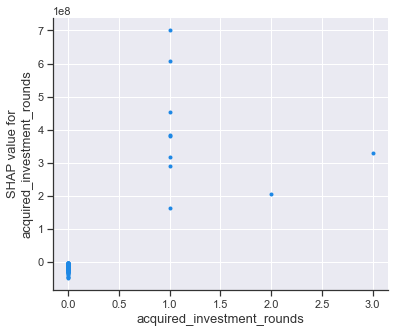

In [37]:
shap.dependence_plot('acquired_investment_rounds', shap_values, X_test, interaction_index=None)

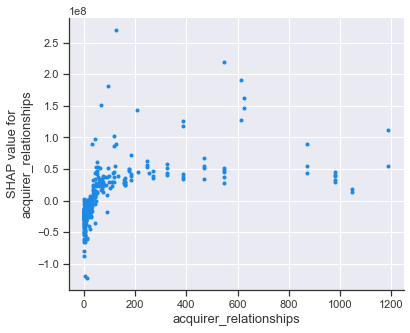

In [38]:
shap.dependence_plot('acquirer_relationships', shap_values, X_test, interaction_index=None)

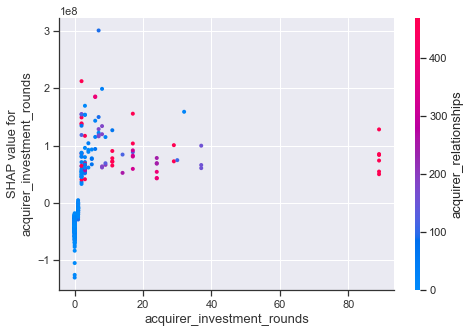

In [39]:
shap.dependence_plot('acquirer_investment_rounds', shap_values, X_test, interaction_index='acquirer_relationships')

**Conclusions**
- similar effects as on the training set
- don't have all the different examples in the test set (ie look at the range of the investment rounds)
- the test set is not a representative subsample of the full dataset, other variables become important